# Pitch & Roll prediction model

In [1]:
import gc
import cv2
import json
import math
import pickle
import random
import platform
import numpy as np
import pandas as pd
import multiprocessing
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

In [3]:
print(torch.__version__)
print(pl.__version__)

1.9.1
1.6.0


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)
cpu_count = multiprocessing.cpu_count()
print('CPU count:', cpu_count)
platform_os = "windows" if platform.system() == "Windows" else "linux"
print("Platform:", platform_os)

# Pytorch Dataloader can't handle n_workers > 0 on windows due to bugs
N_WORKERS = 0 if platform_os=="windows" else cpu_count
print(f"number of workers: {N_WORKERS}")

device: cuda
CPU count: 8
Platform: windows
number of workers: 0


# Constants

In [5]:
N_EPISODES = 540
FRAMES_PER_EPISODE = 400
TRAIN_FOLDER = "../3dmodel/"
SEQUENCE_LENGTH = 50

TRAIN_SIZE = 0.8
N_EPOCHS = 8
BATCH_SIZE = 64
LEARNING_RATE = 0.0001

CUDA = device.type == 'cuda'

# Load data from episodes

In [6]:
# view first episode 
filename = TRAIN_FOLDER+"test_4_episode_1/labels_0.json"
data = []
labels = json.load(open(filename))
ep1 = pd.DataFrame(labels)
ep1 = ep1.transpose()
ep1.rename(columns = {0:'pitch', 1:'roll'}, inplace=True)
ep1.head()

,pitch,roll
0,15.915869,2.358416
1,14.295925,1.700391
2,6.213590,1.611325
3,1.235337,6.175461
4,1.341678,3.695468


In [85]:
# load all data
pr = []
episodes = []
for ep in range(1, N_EPISODES+1):
    filename = "../3dmodel/test_4_episode_"+ str(ep) +"/labels_0.json"
    labels = json.load(open(filename))
    for i in labels:
        pr.append(labels[i])
        episodes.append(labels[i]+[ep, i])

In [86]:
p_r_df = pd.DataFrame(episodes)
p_r_df.rename(columns = {0:'pitch', 1:'roll', 2:'episode', 3:'position_within_episode'}, inplace=True)
p_r_df = p_r_df.astype({"pitch": float, "roll": float})
p_r_df.head()

,pitch,roll,episode,position_within_episode
0,15.915869,2.358416,1,0
1,14.295925,1.700391,1,1
2,6.213590,1.611325,1,2
3,1.235337,6.175461,1,3
4,1.341678,3.695468,1,4


In [87]:
df2 = p_r_df.copy()
df2["pr"] = list(zip(p_r_df["pitch"].round(2), p_r_df["roll"].round(2)))
df2.drop(columns=["pitch","roll"], axis=0, inplace=True)
df2 = df2[["pr","episode","position_within_episode"]]
rows = df2.groupby('episode')['pr'].apply(list)
df_stack = pd.DataFrame(rows)
df_stack = df_stack.reset_index()
df_stack.head()

,episode,pr
0,1,"[(15.92, 2.36), (14.3, 1.7), (6.21, 1.61), (1...."
1,2,"[(15.98, 2.27), (9.86, 1.36), (6.11, 1.56), (1..."
2,3,"[(15.96, 2.07), (6.18, 0.12), (6.08, 1.68), (1..."
3,4,"[(7.7, 1.58), (8.48, 0.06), (3.16, 0.86), (1.0..."
4,5,"[(7.81, 1.49), (7.87, 0.18), (3.13, 0.91), (0...."


In [88]:
# Function to normalize pitch and roll angles
def norm_pr(x, min = -90.0, max = 90.0):
    return ((x - min) * 2) / (max - min) - 1

# Function to denormalize pitch and roll angles
def denorm_pr(x, min = -90.0, max = 90.0):
    return ((x + 1) * (max - min))/2 + min

In [89]:
# normalize PR-values
p_r_df['pitch'] = p_r_df['pitch'].apply(lambda x : norm_pr(x))
p_r_df['roll'] = p_r_df['roll'].apply(lambda x : norm_pr(x))
p_r_df.head()

,pitch,roll,episode,position_within_episode
0,0.176843,0.026205,1,0
1,0.158844,0.018893,1,1
2,0.069040,0.017904,1,2
3,0.013726,0.068616,1,3
4,0.014908,0.041061,1,4


# Create sequences with target value

In [90]:
# function to create sequences with one target column
def create_sequences(input_data: pd.DataFrame, 
        target_columns, 
        sequence_length, 
        feature_columns = ["pitch", "roll"], 
        episode_length = FRAMES_PER_EPISODE, 
        n_episodes = N_EPISODES
    ):
    
    sequences= []
    # get indice(s) for target column(s)
    target_index = [input_data.columns.get_loc(c) for c in target_columns if c in input_data]

    # make sequences per episode, one sequence can only hold data of one and the same episode!
    for n in tqdm(range(n_episodes)):

        for l in range(episode_length-SEQUENCE_LENGTH):
            
            i = l+(n*episode_length)

            sequence = input_data.iloc[i:i+sequence_length][feature_columns]

            target_position = i + sequence_length
            target = input_data.iloc[[target_position], target_index].values.flatten()

            sequences.append((sequence, target))

    return sequences

In [91]:
target = ["pitch","roll"]
all_sequences = create_sequences(p_r_df, target, SEQUENCE_LENGTH)

  0%|          | 0/540 [00:00<?, ?it/s]

In [92]:
len(all_sequences),all_sequences[0][0].shape, all_sequences[0][1].shape 

(189000, (50, 2), (2,))

In [93]:
all_sequences[0][1]

array([0.16445671, 0.13332855])

In [94]:
index = 0
print("Sequence for target value: ", all_sequences[index][1])
pd.concat([all_sequences[index][0].head(2),all_sequences[index][0].tail(2)])

Sequence for target value:  [0.16445671 0.13332855]


,pitch,roll
0,0.176843,0.026205
1,0.158844,0.018893
48,0.176507,0.083474
49,0.181805,0.094970


In [95]:
# Grab random subsets from all sequences for training and test data (without overlapping data)
data_size = len(all_sequences)
data_indices = list(np.arange(0, data_size, 1))

# train indices are random sample from all data indices
random.seed(42)
train_size = int(TRAIN_SIZE * data_size)
train_indices = random.sample(data_indices, train_size)

# test indices are the difference of all data indices and train indices
test_indices = list(set(data_indices) - set(train_indices))

print((len(train_indices) + len(test_indices)) <= data_size)
print(len(train_indices), len(test_indices))
print(train_indices[:10])
print(test_indices[:10])

True
151200 37800
[167621, 29184, 6556, 72097, 64196, 58513, 36579, 26868, 177392, 142964]
[1, 131073, 4, 131077, 6, 131079, 11, 131088, 17, 131089]


In [96]:
# drop temporary episode and position_within_episode columns in all sequences
train_sequences = []
test_sequences = []

for idx in tqdm(train_indices):
    seq = all_sequences[idx][0]
    label = all_sequences[idx][1]
    train_sequences.append((seq,label))

for idx in tqdm(test_indices):
    seq = all_sequences[idx][0]
    label = all_sequences[idx][1]
    test_sequences.append((seq,label))

print((len(train_sequences) + len(test_sequences)) <= len(all_sequences))
print(len(train_sequences), train_sequences[0][0].shape, train_sequences[0][1].shape) 
print(len(test_sequences), test_sequences[0][0].shape, test_sequences[0][1].shape)

  0%|          | 0/151200 [00:00<?, ?it/s]

  0%|          | 0/37800 [00:00<?, ?it/s]

True
151200 (50, 2) (2,)
37800 (50, 2) (2,)


## Pytorch Dataset

In [97]:
class PRDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        sequence, labels = self.sequences[index]

        return dict(
            sequence = torch.Tensor(sequence.to_numpy()),
            labels = torch.Tensor(labels)
        )

In [98]:
class PRDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batchsize = BATCH_SIZE):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batchsize = batchsize

    # turns normal list object into Dataset object
    def setup(self):
        self.train_dataset = PRDataset(self.train_sequences)
        self.test_dataset = PRDataset(self.test_sequences)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = self.batchsize,
            shuffle = False,
            num_workers=N_WORKERS,
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = 1,
            shuffle = False,
            num_workers=N_WORKERS,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = 1,
            shuffle = False,
            num_workers=N_WORKERS,
        )

In [99]:
data_module = PRDataModule(train_sequences, test_sequences, BATCH_SIZE)
data_module.setup()

In [100]:
data_module_train_dataloader = data_module.train_dataloader()
data_module_train_dataloader.dataset.__getitem__(0)["sequence"].shape, data_module_train_dataloader.dataset.__getitem__(0)["labels"]

(torch.Size([50, 2]), tensor([ 0.2262, -0.0693]))

In [101]:
# batch size 64, seq_length, 2 in-/output features
for batch in data_module_train_dataloader:
    print(batch["sequence"].shape)
    print(batch["labels"].shape)
    break

torch.Size([64, 50, 2])
torch.Size([64, 2])


In [102]:
# turn sequence list into Dataset object
train_dataset = PRDataset(train_sequences)

In [103]:
for item in train_dataset:
    print(item["sequence"].shape)
    print(item["labels"].shape)
    print(item["labels"])
    break

torch.Size([50, 2])
torch.Size([2])
tensor([ 0.2262, -0.0693])


## LSTM Model

In [104]:
class PRPredictionModel(nn.Module):

    # INPUT LAYER (2 features) --> LSTM 128 hidden --> LSTM 128 hidden --> Linear --> OUTPUT (2 features)
    def __init__(self, in_features, out_features, n_hidden=128, n_layers=2):
        super().__init__()

        self.n_hidden = n_hidden

        self.lstm = nn.LSTM(
            input_size=in_features,
            hidden_size=n_hidden,
            batch_first=True,
            num_layers=n_layers,
            dropout=0.2
        )

        self.regressor = nn.Linear(in_features=n_hidden, out_features=out_features)

    def forward(self, x):
        # call flatten_parameters function to aggregate all the weight 
        # tensors into continuous space of GPU memory
        self.lstm.flatten_parameters()
    
        output, (hidden_state, cell_state) = self.lstm(x)
        out = hidden_state[-1]

        return self.regressor(out)

# Training

In [105]:
model = PRPredictionModel(2,2)

if CUDA:
    model.cuda()

x_train = 0
y_train = 0

for batch in data_module_train_dataloader:
    x_train = batch["sequence"]
    y_train = batch["labels"]
    break

print(x_train.shape, y_train.shape)

torch.Size([64, 50, 2]) torch.Size([64, 2])


In [106]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
losses_epoch = []
losses_all_batches = []

n_epochs = N_EPOCHS

for epoch in tqdm(range(n_epochs)):

    i = 0
    losses_batch = []

    for batch in data_module_train_dataloader:
        x_train = batch["sequence"]
        y_train = batch["labels"]

        if CUDA: 
            x_train = batch["sequence"].cuda()
            y_train = batch["labels"].cuda()
        
        # Predict on forward pass 
        y_pred = model.forward(x_train)
        if CUDA: 
            y_pred = y_pred.cuda()
            
        # Calculate loss/error
        loss = criterion(y_pred, y_train)
        losses_batch.append(loss)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    losses_all_batches.append((epoch,losses_batch))

    # loss per epoch is average over all batches
    sum = 0
    for l in losses_batch:
        sum += l
    
    mean = sum/len(losses_batch)
    losses_epoch.append(mean)
    print(f"EPOCH {epoch} training loss: {mean}")

  0%|          | 0/8 [00:00<?, ?it/s]

EPOCH 0 training loss: 0.0025173486210405827
EPOCH 1 training loss: 0.002289982046931982
EPOCH 2 training loss: 0.0022317362017929554
EPOCH 3 training loss: 0.002165165264159441
EPOCH 4 training loss: 0.0021238510962575674
EPOCH 5 training loss: 0.0020812328439205885
EPOCH 6 training loss: 0.002038664184510708
EPOCH 7 training loss: 0.001978505402803421


# Training results

In [107]:
losses_epoch
new_tensor = torch.tensor(losses_epoch, device = 'cpu')

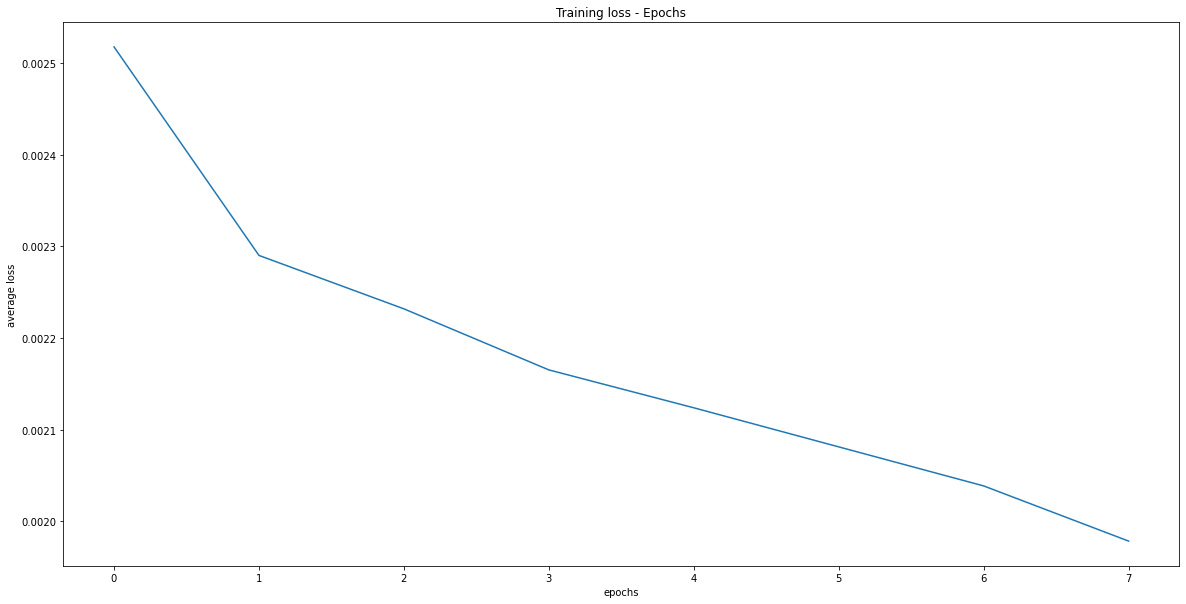

In [108]:
plt.figure(figsize=(20, 10))
plt.plot(range(n_epochs), new_tensor)
plt.title("Training loss - Epochs")
plt.xlabel("epochs")
plt.ylabel("average loss")
plt.show()

In [109]:
modelname = 'model_states/PR_LSTM_seqlength'+str(SEQUENCE_LENGTH)+"_epochs"+str(N_EPOCHS)
torch.save(model.state_dict(), modelname)

In [110]:
loaded_model = PRPredictionModel(in_features=2, out_features=2)
loaded_model.load_state_dict(torch.load(modelname))
if CUDA: 
    loaded_model = loaded_model.cuda()
loaded_model.eval()

PRPredictionModel(
  (lstm): LSTM(2, 128, num_layers=2, batch_first=True, dropout=0.2)
  (regressor): Linear(in_features=128, out_features=2, bias=True)
)

# Testing

In [111]:
x_test = 0
y_test = 0

for batch in data_module.test_dataloader():
    x_test = batch["sequence"]
    y_test = batch["labels"]
    break

if CUDA:
    x_test = x_test.cuda()
    y_test = y_test.cuda()

print(x_test.shape, y_test.shape)

torch.Size([1, 50, 2]) torch.Size([1, 2])


In [112]:
with torch.no_grad():
    y_pred = loaded_model(x_test)
    loss = criterion(y_pred, y_test)
    print(f'prediction:\t{y_pred}\nreal:\t\t{y_test}')
    print("loss:", loss.item())

prediction:	tensor([[0.1273, 0.0922]], device='cuda:0')
real:		tensor([[0.2538, 0.1659]], device='cuda:0')
loss: 0.01071365550160408


In [113]:
predictions = []
labels = []

with torch.no_grad():
    for batch in tqdm(data_module.test_dataloader()):
        x_test = batch["sequence"]
        y_test = batch["labels"]

        if CUDA:
            x_test = x_test.cuda()
            y_test = y_test.cuda()

        output = loaded_model(x_test)
        predictions.append(output.detach().to('cpu').numpy().flatten())
        labels.append(y_test.detach().to('cpu').numpy().flatten())

  0%|          | 0/37800 [00:00<?, ?it/s]

In [114]:
# Predictions[0] = np array object
# Predictions[0][0] = pitch value
# Predictions[0][1] = roll value

pitch_predictions = []
roll_predictions = []

pitch_label = []
roll_label = []

for i in range(len(predictions)):
    pitch_predictions.append(predictions[i][0])
    roll_predictions.append(predictions[i][1])
    pitch_label.append(labels[i][0])
    roll_label.append(labels[i][1])

### Pitch results

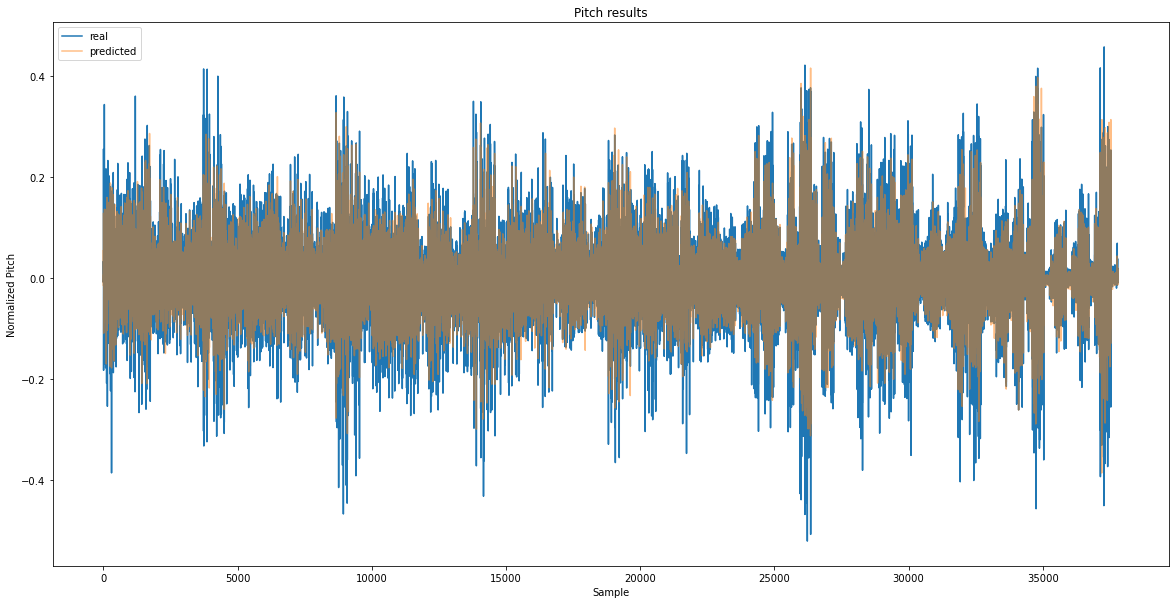

In [126]:
plt.figure(figsize=(20, 10))
plt.plot(pitch_label, label="real")
plt.plot(pitch_predictions, label="predicted", alpha=0.5)
plt.title("Pitch results")
plt.xlabel("Sample")
plt.ylabel("Normalized Pitch")
plt.legend()

In [116]:
n = len(pitch_predictions)
loss = 0
loss0 = 0

for i in range(n):
    loss += (pitch_label[i]-pitch_predictions[i])**2
    loss0 += (pitch_label[i]-0)**2

mse = loss/n
rmse = math.sqrt(loss/n)
mse0 = loss0/n
rmse0 = math.sqrt(loss0/n)

print("Real prediction")
print("   MSE:", mse)
print("   RMSE:", rmse)
print("   RMSE denorm:", denorm_pr(rmse))
print("Zero prediction")
print("   MSE 0:", mse0)
print("   RMSE 0:", rmse0)
print("   RMSE 0 denorm:", denorm_pr(rmse0))
print("Improvement on zero prediction:")
print("   MSE delta%:", round(mse0/mse*100, 2), "%")
print("   RMSE delta%:", round(rmse0/rmse*100, 2), "%")

Real prediction
   MSE: 0.0023889003740309223
   RMSE: 0.04887637848727054
   RMSE denorm: 4.39887406385435
Zero prediction
   MSE 0: 0.005114845834506637
   RMSE 0: 0.07151815038510599
   RMSE 0 denorm: 6.436633534659535
Improvement on zero prediction:
   MSE delta%: 214.11 %
   RMSE delta%: 146.32 %


### Roll results

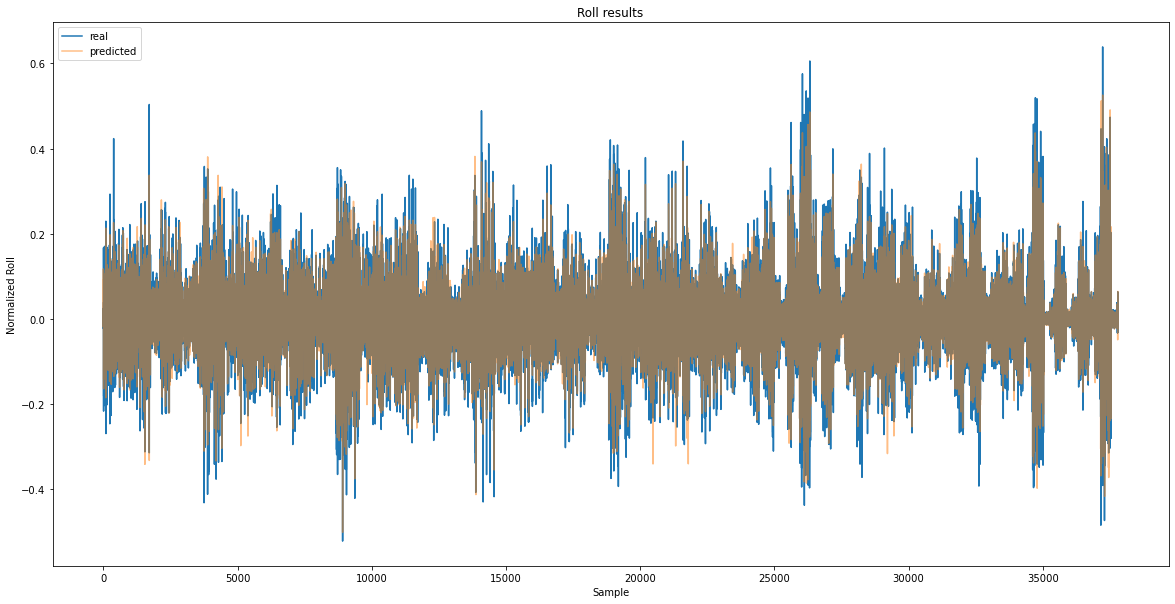

In [124]:
plt.figure(figsize=(20, 10))
plt.plot(roll_label, label="real")
plt.plot(roll_predictions, label="predicted", alpha=0.5)
plt.title("Roll results")
plt.xlabel("Sample")
plt.ylabel("Normalized Roll")
plt.legend()

In [118]:
n = len(roll_predictions)
loss = 0
loss0 = 0

for i in range(n):
    loss += (roll_label[i]-roll_predictions[i])**2
    loss0 += (roll_label[i]-0)**2

mse = loss/n
rmse = math.sqrt(loss/n)
mse0 = loss0/n
rmse0 = math.sqrt(loss0/n)

print("Real prediction")
print("   MSE:", mse)
print("   RMSE:", rmse)
print("   RMSE denorm:", denorm_pr(rmse))
print("Zero prediction")
print("   MSE 0:", mse0)
print("   RMSE 0:", rmse0)
print("   RMSE 0 denorm:", denorm_pr(rmse0))
print("Improvement on zero prediction:")
print("   MSE delta%:", round(mse0/mse*100, 2), "%")
print("   RMSE delta%:", round(rmse0/rmse*100, 2), "%")

Real prediction
   MSE: 0.0015488392466626957
   RMSE: 0.03935529502700616
   RMSE denorm: 3.5419765524305546
Zero prediction
   MSE 0: 0.0065761528051619875
   RMSE 0: 0.08109348189072897
   RMSE 0 denorm: 7.298413370165605
Improvement on zero prediction:
   MSE delta%: 424.59 %
   RMSE delta%: 206.05 %
